In [ ]:
import numpy as np
import pandas as pd
import math

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 200
batch_size = 64

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NhanDangCamXuc_CSV/fer2013.csv')

In [ ]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

In [ ]:
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


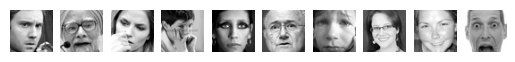

In [ ]:
import matplotlib.pyplot as plt
for i in range(0, 10):
  plt.subplot(1, 10, i+1)
  plt.imshow(train_X[i], cmap = 'gray')
  plt.axis("off")
plt.show()

<ipython-input-11-3dee006c2af4>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


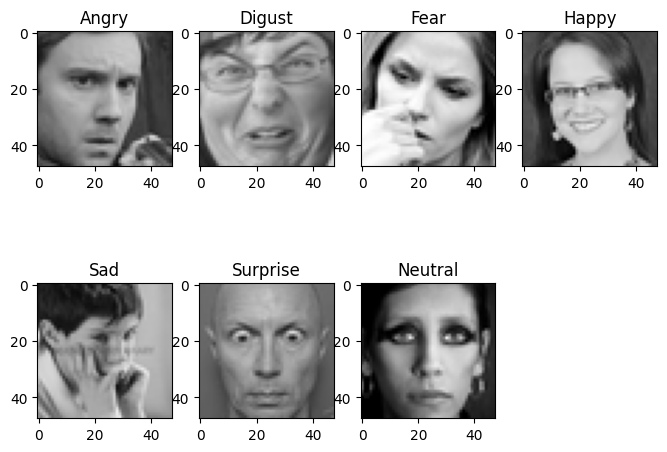

In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(8,6))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0],)
    plt.title(img[1])

plt.show()

In [ ]:
# Define the model architecture
model = Sequential()


model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_22 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_23 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_accuracy',
                         patience=20,
                         restore_best_weights=True)

In [ ]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

val_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_set = data_generator.flow(train_X, train_Y, batch_size = 64)
val_set = data_generator.flow(val_X, val_Y, batch_size = 64)

In [ ]:
history = model.fit(train_set,
                    epochs=num_epochs,
                    batch_size = 64,
                    validation_data= val_set,
                    steps_per_epoch= math.ceil(len(train_X) / batch_size),
                    callbacks= callback,)


Epoch 1/200
449/449 [==============================] - 27s 48ms/step - loss: 1.9953 - accuracy: 0.2841 - val_loss: 1.8192 - val_accuracy: 0.2970
Epoch 2/200
449/449 [==============================] - 23s 50ms/step - loss: 1.4965 - accuracy: 0.4170 - val_loss: 1.3813 - val_accuracy: 0.4739
Epoch 3/200
449/449 [==============================] - 21s 47ms/step - loss: 1.3366 - accuracy: 0.4845 - val_loss: 1.3476 - val_accuracy: 0.4806
Epoch 4/200
449/449 [==============================] - 21s 47ms/step - loss: 1.2539 - accuracy: 0.5203 - val_loss: 1.2180 - val_accuracy: 0.5283
Epoch 5/200
449/449 [==============================] - 23s 51ms/step - loss: 1.1985 - accuracy: 0.5468 - val_loss: 1.3149 - val_accuracy: 0.4971
Epoch 6/200
449/449 [==============================] - 21s 47ms/step - loss: 1.1472 - accuracy: 0.5664 - val_loss: 1.2068 - val_accuracy: 0.5422
Epoch 7/200
449/449 [==============================] - 22s 49ms/step - loss: 1.1167 - accuracy: 0.5813 - val_loss: 1.1526 - val_ac

In [ ]:
model.save("/content/drive/MyDrive/NhanDangCamXuc/emotion_detection_v9.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


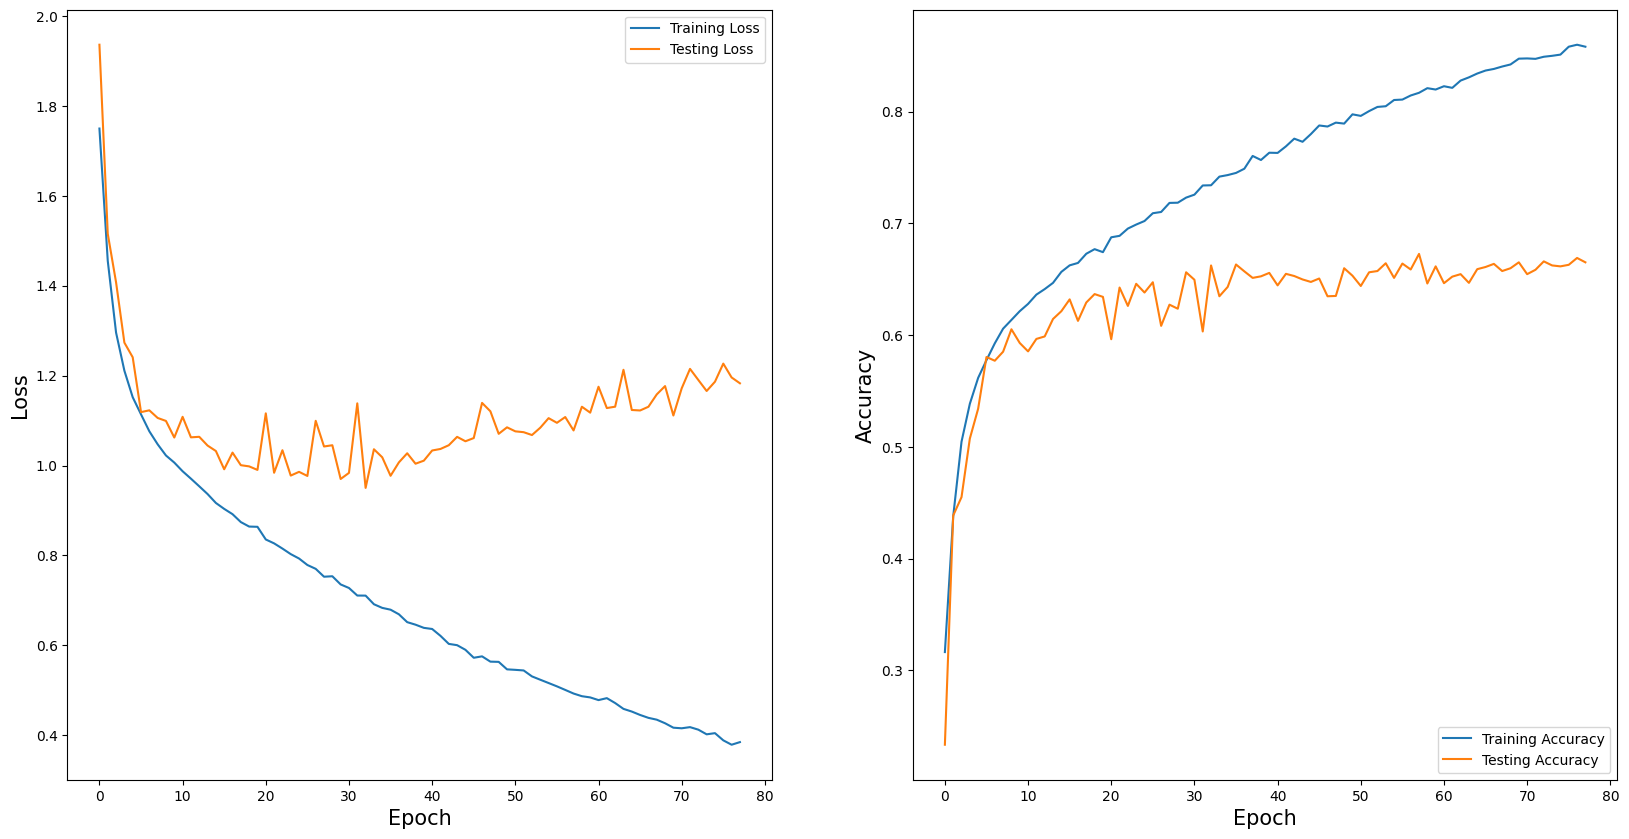

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 1s 5ms/step
CNN Model Accuracy on test set: 0.6871


In [ ]:
train_true = np.argmax(train_Y, axis=1)
train_pred = np.argmax(model.predict(train_X), axis=1)
print("CNN Model Accuracy on train set: {:.4f}".format(accuracy_score(train_true, train_pred)))

898/898 [==============================] - 6s 6ms/step
CNN Model Accuracy on train set: 0.7801


In [ ]:
test_generator = ImageDataGenerator()
test_set = test_generator.flow(test_X, test_Y, batch_size = 64)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/NhanDangCamXuc/emotion_detection_v5.h5')

In [ ]:
score = model.evaluate(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

57/57 [==============================] - 1s 10ms/step - loss: 0.9795 - accuracy: 0.6927
Test loss: 0.9794826507568359
Test accuracy: 0.692672073841095


In [ ]:
#classification Report
from sklearn.metrics import classification_report
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print('Classification Report')
target_names = emotion_labels
print(classification_report(test_true, test_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Angry       0.62      0.63      0.62       491
     Disgust       0.80      0.58      0.67        55
        Fear       0.58      0.49      0.53       528
       Happy       0.85      0.91      0.88       879
         Sad       0.58      0.54      0.56       594
    Surprise       0.78      0.78      0.78       416
     Neutral       0.64      0.71      0.67       626

    accuracy                           0.69      3589
   macro avg       0.69      0.66      0.67      3589
weighted avg       0.69      0.69      0.69      3589



In [ ]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


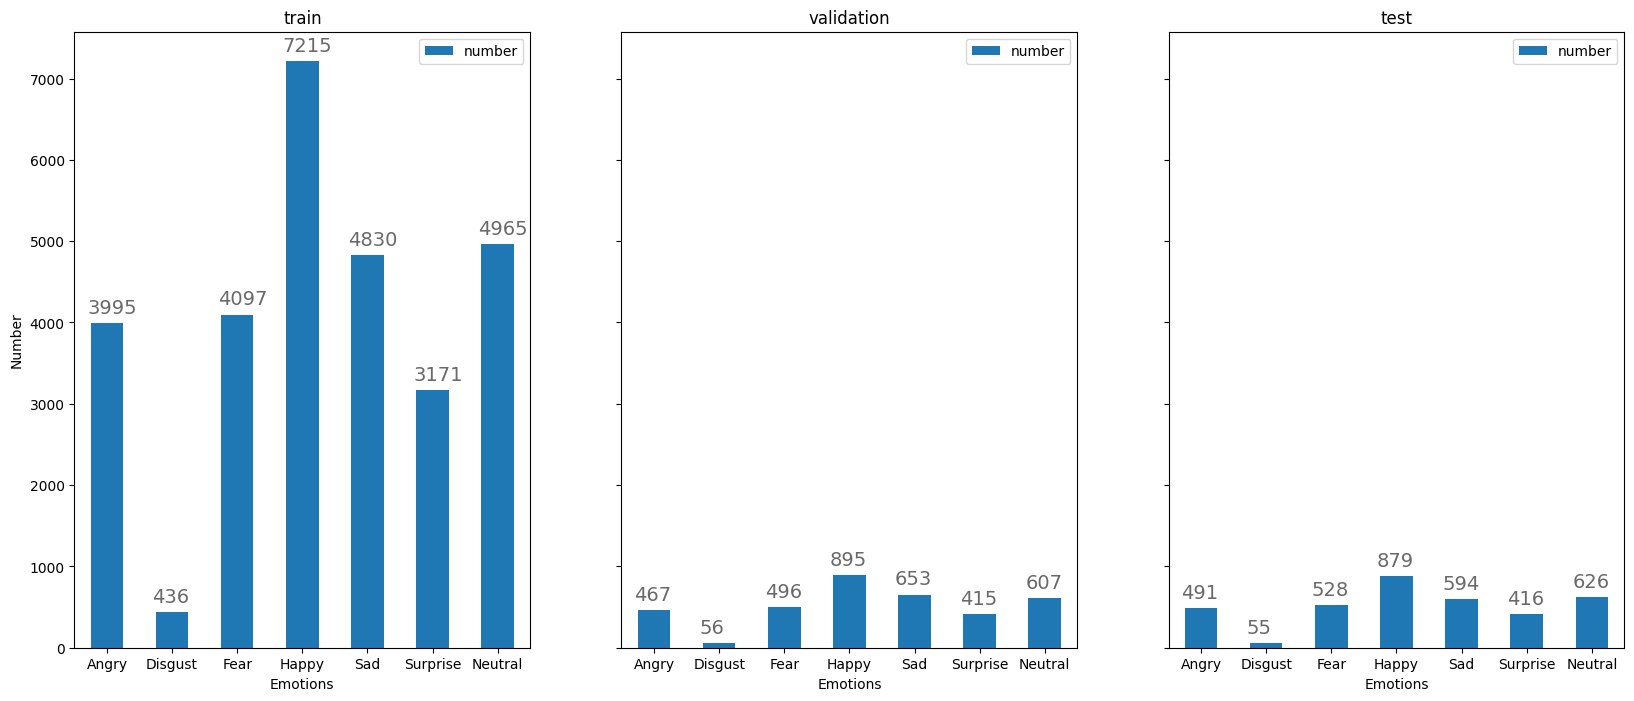

In [ ]:
import matplotlib.pyplot as plt
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def setup_axe(axe,df,title):
    emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
    emotion_counts.columns = ['emotion', 'number']
    emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
    emotion_counts.plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

df_sorted_train = data_train.sort_values(by='emotion')
df_sorted_val = data_val.sort_values(by='emotion')
df_sorted_test = data_test.sort_values(by='emotion')
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],df_sorted_train,'train')
setup_axe(axes[1],df_sorted_val,'validation')
setup_axe(axes[2],df_sorted_test,'test')
plt.show()